# Pset on Inference

[Download notebook :fontawesome-solid-download:](../cps_inference.ipynb){: .md-button .md-button--primary download="cps_inference.ipynb"}

Goal of the problem set:

 - understand heteroskedasticity and clustered standard errors
 - familiarize yourself with `pandas`, grouping and formating
 - [TBD] learn about `numba` to accelerate your code for large data-sets
 
some useful references:

 - [OLS in python](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)
 - [OLS with formulas](https://www.statsmodels.org/devel/example_formulas.html)
 - [pandas transorm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html)
 - [method chaining in pandas](https://tomaugspurger.github.io/method-chaining.html)
 - [progress bars](https://tqdm.github.io/)
 
We are going to reproduce an exercise similar to the example for the computation of standard error.  Start by downloading the CPS data from [here](http://cameron.econ.ucdavis.edu/research/cameron_miller_JHR_files%20to%20share.zip).  We first load the needed libraries, my solutions wich are hidden to you and the data.

In [2]:
%cd ..
%load_ext autoreload
%autoreload 2
from solutions.sol_pset2 import *
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm


/home/tlamadon/git/econ-21340


In [3]:
data = pd.read_stata("data/CPS_2012_micro.dta")

Next generate a fictuous policy that you randomly assigned at the state times gender level. Run the regression and report standard errors given by R for one draw of the poilcy.

In [5]:
np.random.seed(60356548) # I fix the seed to make sure the draws are reproducible

# we draw the policy for each state
fpol = { k:np.random.uniform() > 0.5 for k in np.unique(data['statefip']) }
data['fp'] = data['statefip'].map(fpol)

data

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp
0,2012,Maine,569.43,44,Female,14.0,7.020000,1.948763,1936.0,True
1,2012,Maine,595.47,25,Male,16.0,2.117143,0.750067,625.0,True
2,2012,Maine,635.66,61,Female,16.0,16.672501,2.813761,3721.0,True
3,2012,Maine,635.66,62,Male,16.0,17.784000,2.878299,3844.0,True
4,2012,Maine,513.39,25,Female,12.0,9.633000,2.265195,625.0,True
...,...,...,...,...,...,...,...,...,...,...
65680,2012,Hawaii,282.87,24,Male,16.0,28.899000,3.363807,576.0,False
65681,2012,Hawaii,362.23,49,Male,18.0,18.525000,2.919121,2401.0,False
65682,2012,Hawaii,362.23,44,Female,20.0,18.525000,2.919121,1936.0,False
65683,2012,Hawaii,282.87,28,Male,18.0,24.082500,3.181485,784.0,False


!!! question "Question 1"
    As an exercise to get acquainted with pandas, here I would like for you to implement the following procedure:
    
1. compute the average wage in each state for each age decile (less than 20, betwen 20 and 30, ...)
2. [pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) the table with states in rows and age deciles in columns
3. using [pandas styling](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html), I want you to highlight the lowest wage in each age decile and I want you to format the average wage with onely 2 decimal points.


In [6]:
# we tabulate the counts by age group and state
tibo_question1(data)

age_grp,20.0,30.0,40.0,50.0,60.0,70.0
statefip,,,,,,
Alabama,8.20,11.33,15.50,19.39,17.38,15.21
Alaska,8.68,14.14,19.92,19.59,20.67,20.46
Arizona,9.76,11.97,16.55,18.63,18.46,21.30
Arkansas,6.52,12.47,14.95,17.36,16.13,14.26
California,8.52,12.82,18.98,20.55,21.52,21.34
Colorado,9.63,12.35,19.19,21.00,21.80,21.29
Connecticut,6.79,13.29,20.98,24.64,25.11,20.69
Delaware,6.05,12.61,17.07,19.70,17.89,20.10
District of Columbia,10.24,17.36,26.19,25.80,25.35,29.54


## A first regression

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('lnwage ~ fp', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnwage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.53
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           0.000687
Time:                        10:04:10   Log-Likelihood:                -62336.
No. Observations:               65685   AIC:                         1.247e+05
Df Residuals:                   65683   BIC:                         1.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6687      0.003    836.168      0.0

Note We do not control for state specific fixed effect as these would would be perfectly colinear with the policy.

Now this is surprising. We generated `fp` randomly across states, yet we find a **significant effect** of the policy on log wages. To gain understanding on what is happening we will generate our own data in a way where we control exactly what is happening.



## IID errors

Let's start by reassuring ourselves. Let's use an IID data generating process (DGP), run the regression and check the significance.

 1. compute the variance of `lnwage` in the sample. This is an estimate of our homoskedastic error.
 2. simulate a fictuous outcome `y2` simply equal to normal error with the estimated variance, and truly independent across individuals. Use `.assign(y2 = ...)` on the pandas dataFrame.
 3. regress this outcome `y2` on `fp`, our fictuous policy and collect the coefficient, also save if the coefficient is significant at 5%.
 4. run steps (2,3) 500 times.
 
!!! question "Question 2"
    Follow the previous steps and report how often we would consider teh coefficient on `fp`significant at 5%. You should find something close to 5% and you should feel better about the theory!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:52<00:00,  4.46it/s]


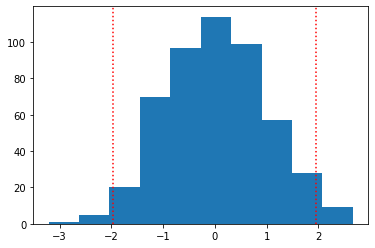

In [8]:
# I colled tstats across 500 replications and plot the histogram
tstats = tibo_question2(data)
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [9]:
# I check that the distribution is outside of the 0.025 to 0.0975 quantiles of the normal with probability close to 0.05
(np.abs(tstats)>1.96).mean()

0.038

## Back to using wages in data

We go back and we do the same exercise, only this time we redraw the policy in each replciations and regress the wages on it, and collect the t-stats. We then plot the histogram of the t-stats and compute the probability of rejecting the null that the coefficient on the policy is 0. 

!!! question "Question 3"
    Replicate 500 times the very first regression to recreate an histogram of t-stats similar to the following one. Compute the probability to reject the null of effect and comment on its value given the way you simulated the data (2 sentences max).

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


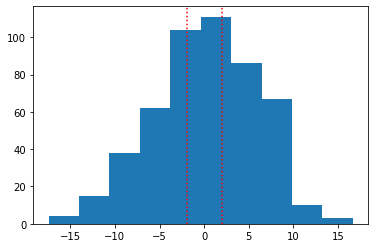

In [10]:
tstats = tibo_question3(data)
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

## Heteroskedastic errors

Now we want to simulate heteroskedastic robust standard errors which requires us to use some co-variates. We then want to repeat the previous procedure, but we are going to use a different code for simulation and a new test for the significance. `statsmodels` can do that for you using the `cov_type` argument of the `fit` method.

We want to check this by simulating from a model with heteroskedesatic errors. To do so we are going to use linear model for the variance:

$$ y_{i} = 0 + s(x_i) \cdot \epsilon_i$$

We are going to use a linear specification for $s^2(x_i)$. 

 1. run the following regression `lnwage ~ yrseduc + age + age^2` to get the $m(x_i) = x_i' \beta$ where the $x_i$ are education, age and age squared. 
 2. extract the residuals $\hat{u}_i$ from the previous regression. Then regress $\hat{u}^2_i$ on `yrseduc + age + age^2`, to get the $s^2(x_i) = x_i' \gamma$ model.
 2. using $s^2(x_i) = x_i' \gamma$, construct $ y_{i} = 0 + s(x_i) \cdot \epsilon_i$ where $\epsilon_i$ is drawn iid Normal(0,1).
 5. replicate this 500 times, evaluate the significance of `fp` using heteroskedastic roduct inference by calling `.fit(cov_type='HC0')`, also save without using the robust errors.

!!! question "Question 4"
    Follow the steps and report the distributions of t-stats, as well as the rejection rates for each of the two variance specifications.

In [11]:
tstats = tibo_question4(data,R=500)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:54<00:00,  2.13it/s]


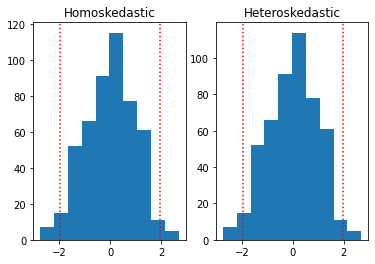

In [12]:
plt.subplot(1,2,1)
plt.hist(tstats[:,0])
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Homoskedastic')

plt.subplot(1,2,2)
plt.hist(tstats[:,1])
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")
plt.title('Heteroskedastic')

plt.show()

## State clustered errors

We are going to simulate corrolated error within state. To do so we continue to draw independent error terms $u_i$ but we add to them a common draw at the state level. In practice you can do that by doing similar to drawing the `fp`. We then create the outcome as 

$$y_{ig} = (1-\rho) u_i + \rho v_g $$

Here is a way of doing this: 

In [13]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

!!! question "Question 5"
    First, explain the `groupby` expression. Next find another way of doing line 2 and 3, but try to minize the number of characters (see [python golfing](https://www.geeksforgeeks.org/code-golfing-in-python/) or more generaly [wikipedia](https://en.wikipedia.org/wiki/Code_golf)).

Before we get started estimating the effect of the policy, let's write a function that computes the within state correlation in the error term. 

To that end draw 500 pairs of people where the 2 people in a pair belong to the same state. This gives you 2 vector of length 500. Compute the correlation between these 2 vectors. Use the `sample` and `query` methods of `pandas`. Similarly construct a placebo function that just takes random pairs of workers without imposing that they come from the same state.

!!! question "Question 6"
    Write your own version of the `tibo_pair_cor` and `tibo_cor_placebo` functions, see what my version delivers:

In [14]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(tibo_pair_cor(data))
print(tibo_pair_cor_placebo(data))

rho=0.8
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(tibo_pair_cor(data))
print(tibo_pair_cor_placebo(data))

0.3897776020016869
-0.040966125092058624
0.9456602724962486
0.02788388532066169


We are then going to replicate the data construction 500 times.

!!! question "Question 7"
    For $\rho=0.2,0.5,0.8$ run 500 replications and report the proportion at each value of $\rho$ for which the coefficient on$\text{fp}$ is significant at 5%. Report the results for three different regression using regular `fit`, using `cov_type='HC0'` and using `cov_type='cluster'`.

In [15]:
# here is an example of clusetered errors 
rho=0.8
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

data['y'] =  data.v
results = smf.ols('y ~ fp', data=data).fit(cov_type='cluster',cov_kwds={"groups":data['statefip']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.032
Date:                Sun, 14 Nov 2021   Prob (F-statistic):              0.160
Time:                        10:12:05   Log-Likelihood:                -78551.
No. Observations:               65685   AIC:                         1.571e+05
Df Residuals:                   65683   BIC:                         1.571e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0427      0.182      0.235      0.8

In [16]:
# and here the regression without clustered standard errors
rho=0.8
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

data['y'] =  data.v
results = smf.ols('y ~ fp', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     157.1
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           5.32e-36
Time:                        10:12:05   Log-Likelihood:                -75824.
No. Observations:               65685   AIC:                         1.517e+05
Df Residuals:                   65683   BIC:                         1.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0335      0.005     -7.138      0.0